## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.utils import resample

%matplotlib inline

## Read in data

In [2]:
housing = pd.read_csv('data/boston_house_prices.csv')
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Update to a cross-validated approach


### TODO:
* [x] Do a train-test split
* [x] Do cross-validation and regularization
* [x] Estimate parameters using Bootstrapping

In [3]:
features = housing.drop('MEDV', axis=1)
target = housing['MEDV']

In [4]:
# Add in new features
features['RM_sq'] = features['RM']**2
features['log_LSTAT'] = np.log1p(features['LSTAT'])

In [5]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           random_state=42)


## Pipelining

We should be scaling our data inside each fold, so we should group the scaler and the Lasso regression into a pipeline.

In [6]:
scaler = RobustScaler()
lasso_regressor = Lasso()

pipeline = Pipeline([
    ('scaler', scaler),
    ('lasso', lasso_regressor)
])

params = {
    'lasso__alpha': np.logspace(-4, 2, 100)
}

In [7]:
grid = GridSearchCV(pipeline, param_grid=params, cv=5, iid=False, return_train_score=True)
grid.fit(features_train, target_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'lasso__alpha': array([1.00000e-04, 1.14976e-04, ..., 8.69749e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [8]:
# What is the best value of alpha?
grid.best_estimator_.named_steps['lasso'].alpha

0.01

In [9]:
# what is our best mean test score?
best_result_index = np.argmax(grid.cv_results_['mean_test_score'])
grid.cv_results_['mean_test_score'][best_result_index]

0.7959321716969189

In [10]:
# Check this has the best alpha described above?
grid.cv_results_['param_lasso__alpha'][best_result_index]

0.01

Success! 

Our average $R^2$ on the hold out set is 0.7959.

We should reserve the test set for when we have our final model that we want to use.

In [11]:
best_alpha = grid.best_estimator_.named_steps['lasso'].alpha

## Bootstrapping

In [12]:
n_samples = 1000
coefficients = np.zeros((n_samples, features_train.shape[1]))
pipeline.set_params(lasso__alpha=best_alpha)

for row in range(n_samples):
    feature_set = resample(features_train)
    pipeline.fit(feature_set, target_train[feature_set.index])
    coefficients[row, :] = pipeline.named_steps['lasso'].coef_

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

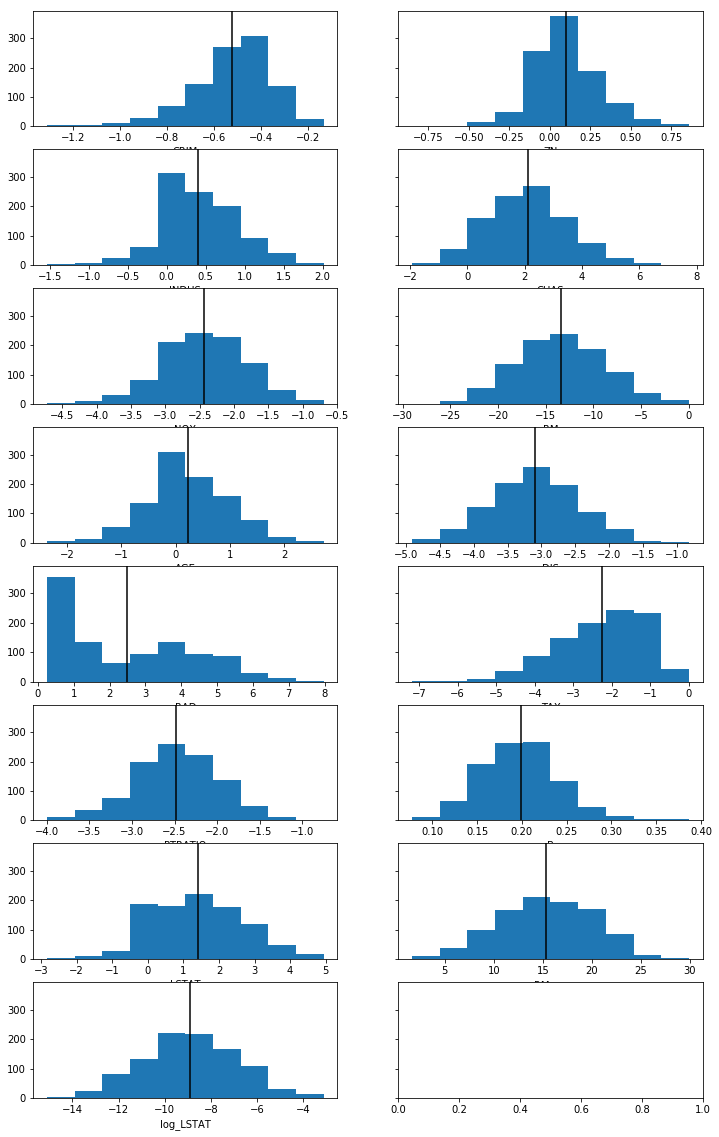

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=len(features.columns)//2 + 1, 
                         sharey=True, squeeze=True, figsize=(12,20))

for index, feature_name in enumerate(features_train.columns):
    feature_values = features_train[feature_name]
    best_est = np.mean(coefficients[:, index])
    
    col = index % 2
    row = index // 2
    this_plot = axes[row][col]
    this_plot.hist(coefficients[:, index])
    this_plot.set_xlabel(feature_name)
    this_plot.axvline(best_est, color='k')

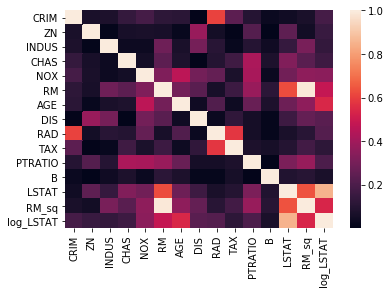

In [14]:
import seaborn as sns

sns.heatmap(abs(pd.DataFrame(coefficients, columns=features.columns).corr()))

Some of these coefficients, such as `LSTAT`, `log_LSTAT`, `RM`, `RM_sq`, `RAD`, and `TAX` seem to be highly correlated. 

## Now make the model using all the training data

In [15]:
best_pipeline = pipeline.set_params(lasso__alpha=best_alpha)
best_pipeline.fit(features_train, target_train)

Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

While working on this, let's look at the coefficients of the `lasso_regressor`. It is common to use lasso (aka L1 regression) to do feature selection, as it tends to set the coefficients of unimportant features to zero (at least more aggressively than ridge does).

In [16]:
best_pipeline.named_steps['lasso'].coef_

array([ -0.50002798,   0.11634726,   0.35107776,   1.97564197,
        -2.48959564, -13.1041632 ,   0.22915318,  -3.19124254,
         2.49327597,  -2.84810478,  -2.58035193,   0.19445818,
         1.45585243,  15.00444862,  -9.00026506])

None of the coefficients were chosen as unimportant, i.e. Lasso set none of the coefficients to zero. After scaling, the coefficients are more or less comparable. Let's get a ranking of the most important features: 

In [17]:
feature_importance = sorted(zip(best_pipeline.named_steps['lasso'].coef_, features.columns), 
                            key=lambda x: abs(x[0]),
                            reverse=True)
for coef, name in feature_importance:
    print(f'{name:10s} {coef:6.4f}')

RM_sq      15.0044
RM         -13.1042
log_LSTAT  -9.0003
DIS        -3.1912
TAX        -2.8481
PTRATIO    -2.5804
RAD        2.4933
NOX        -2.4896
CHAS       1.9756
LSTAT      1.4559
CRIM       -0.5000
INDUS      0.3511
AGE        0.2292
B          0.1945
ZN         0.1163


In [18]:
best_pipeline.score(features_train, target_train)

0.8303996500507633

Let's start organizing results into a table. We are removing test results, and only want to look at validation results. The training $R^2$ tells us how we did after retraining on all the training data

| Method | Train $R^2$ | Validation $R^2$ |
| --- | --- | --- |
| OLS (Excel) | 0.74064 | N/A |
| OLS (Python)| 0.74064 | N/A |
| LassoCV (Python, scaled) | 0.7477 | N/A |
| LassoCV (Python, scaled, extra features) |0.8303 | 0.7959 |

Our test score is significantly lower than our training score, suggesting that our model is still overfitting.

## Plot of residuals

In Excel, we include a plot of residuals for every feature. We will do the same thing here

In [19]:

residuals = target_train - best_pipeline.predict(features_train)

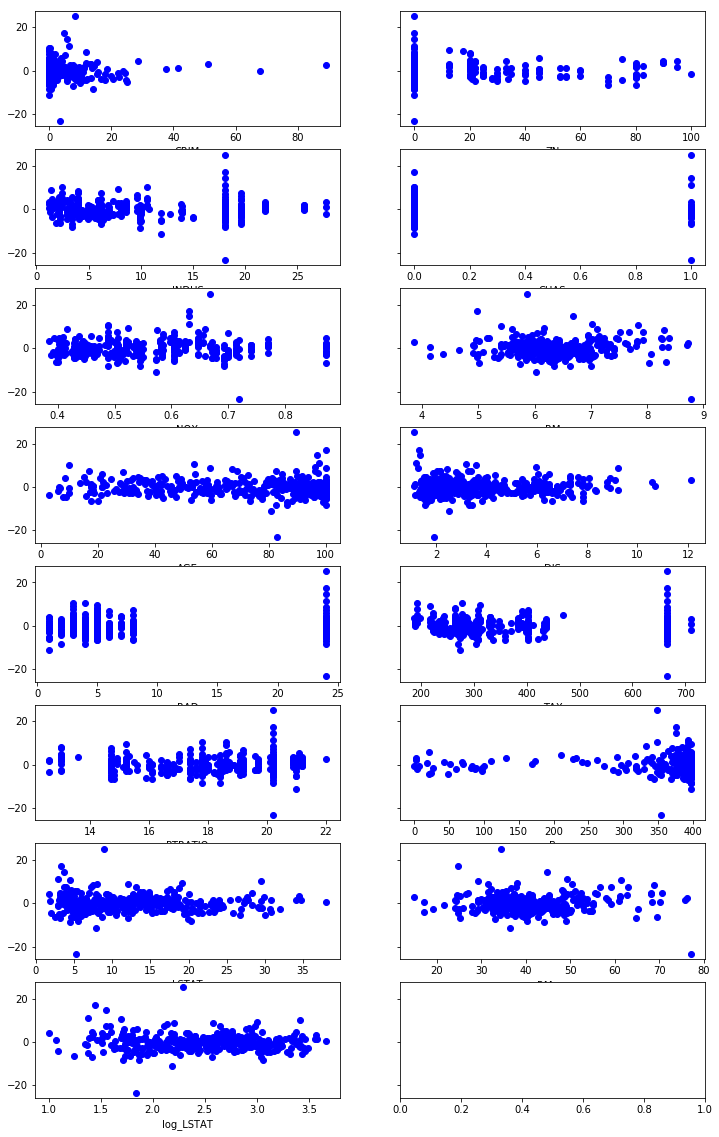

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=len(features.columns)//2 + 1, 
                         sharey=True, squeeze=True, figsize=(12,20))

for index, feature_name in enumerate(features_train.columns):
    feature_values = features_train[feature_name]
    col = index % 2
    row = index // 2
    this_plot = axes[row][col]
    this_plot.plot(feature_values, residuals, 'bo')
    this_plot.set_xlabel(feature_name)